<a href="https://colab.research.google.com/github/eugeneberta/Exercice_tech/blob/main/Bilberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/eugeneberta/Exercice_tech.git

fatal: destination path 'Exercice_tech' already exists and is not an empty directory.


In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import os

Data augmentation :

In [24]:
# imports for data augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import save_img
from matplotlib import pyplot
import cv2

Creating a folder for augmented dataset :

In [25]:
!rm -r Exercice_tech/augmented_data/

In [26]:
!mkdir "Exercice_tech/augmented_data/"
!mkdir "Exercice_tech/augmented_data/road/"
!mkdir "Exercice_tech/augmented_data/field/"

The first thing we do is to save each image and a flipped version in the augmented dataset.
Explain why horizontal flip is a good practice for our problem.

In [27]:
directory = 'Exercice_tech/data/field/'
for filename in os.listdir(directory):
  image = cv2.imread(directory+filename)
  flipped_image= cv2.flip(image, 1)
  cv2.imwrite("Exercice_tech/augmented_data/field/"+filename,image)
  cv2.imwrite("Exercice_tech/augmented_data/field/"+"flip_"+filename,flipped_image)

directory = 'Exercice_tech/data/road/'
for filename in os.listdir(directory):
  image = cv2.imread(directory+filename)
  flipped_image= cv2.flip(image, 1)
  cv2.imwrite("Exercice_tech/augmented_data/road/"+filename,image)
  cv2.imwrite("Exercice_tech/augmented_data/road/"+"flip_"+filename,flipped_image)

For each image in the augmented dataset we create 3 new images with different levels of luminosity.
Explain why luminosity shift is appropriate for our problem.

In [28]:
directory = 'Exercice_tech/augmented_data/field/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(brightness_range=[0.3,2.0])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(3):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    save_img("Exercice_tech/augmented_data/field/"+filename.split(".")[0]+"_luminosity_sample"+str(i)+".jpg",image)


directory = 'Exercice_tech/augmented_data/road/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(brightness_range=[0.3,2.0])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(3):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    save_img("Exercice_tech/augmented_data/road/"+filename.split(".")[0]+"_luminosity_sample"+str(i)+".jpg",image)

For each image we will create 10 new images with randoms shifts, rotations and zooms.

In [29]:
directory = 'Exercice_tech/augmented_data/field/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rotation_range=90, zoom_range=[0.5,1.0])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(5):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    save_img("Exercice_tech/augmented_data/field/"+filename.split(".")[0]+"_random_transfo"+str(i)+".jpg",image)


directory = 'Exercice_tech/augmented_data/road/'
for filename in os.listdir(directory):
  img = load_img(directory+filename)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, rotation_range=90, zoom_range=[0.5,1.0])
  iterator = datagen.flow(samples, batch_size=1)
  for i in range(5):
    batch = iterator.next()
    image = batch[0].astype('uint8')
    save_img("Exercice_tech/augmented_data/road/"+filename.split(".")[0]+"_random_transfo"+str(i)+".jpg",image)

In [30]:
data_dir = 'Exercice_tech/augmented_data/'

def load_split_train_test(datadir, valid_size = .2):
    
    train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=50)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=50)

    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['field', 'road']


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)

print(device)

cuda


In [32]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses, test_accuracies = [], [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            test_accuracies.append(accuracy/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'road_field.pth')

Epoch 1/1.. Train loss: 1.453.. Test loss: 0.151.. Test accuracy: 0.946
Epoch 1/1.. Train loss: 0.462.. Test loss: 0.105.. Test accuracy: 0.959
Epoch 1/1.. Train loss: 0.333.. Test loss: 0.357.. Test accuracy: 0.869
Epoch 1/1.. Train loss: 0.360.. Test loss: 0.081.. Test accuracy: 0.969
Epoch 1/1.. Train loss: 0.152.. Test loss: 0.051.. Test accuracy: 0.981
Epoch 1/1.. Train loss: 0.134.. Test loss: 0.045.. Test accuracy: 0.982
Epoch 1/1.. Train loss: 0.072.. Test loss: 0.043.. Test accuracy: 0.984


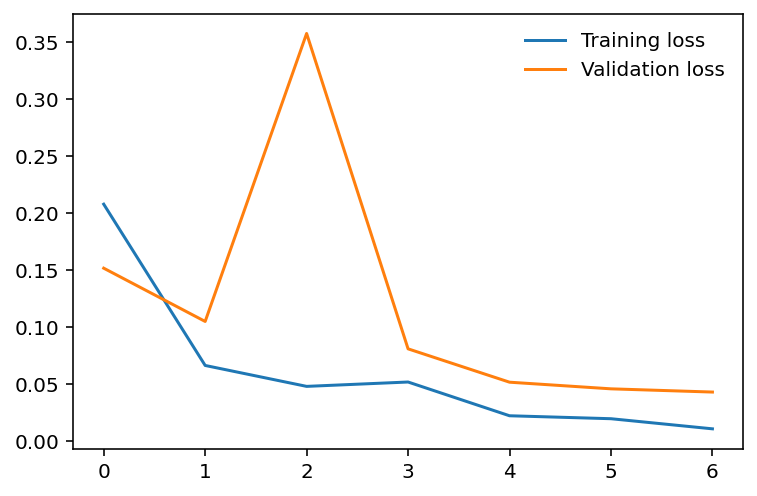

In [34]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

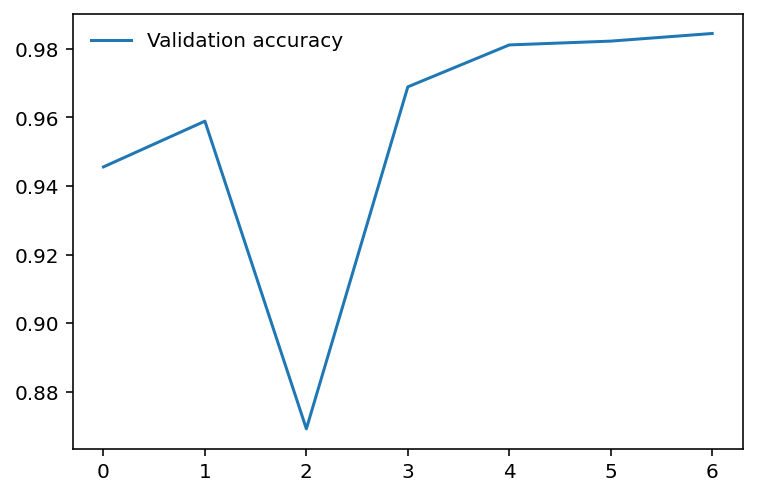

In [39]:
#plt.plot(train_accuracy, label='Training accuracy')
plt.plot(test_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('road_field.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [41]:
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
classes = ['field', 'road']

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

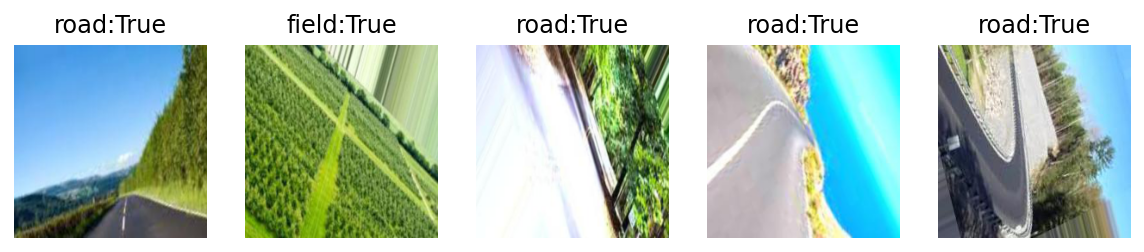

In [52]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()